In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as geo
from mortgage import Loan 
import requests
import irr
import calendar
import math
import sqlite3
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
con = sqlite3.connect(r"C:\Users\Pavan\OneDrive\Desktop\HMDAData.db")

In [3]:
cur = con.cursor()

In [4]:
query='''SELECT DISTINCT("derived_msa-md") 
        FROM cleaned_2018'''
msas=pd.read_sql_query(query, con)["derived_msa-md"]
len(msas)

403

In [5]:
def get_data_2018(MSA):
    query=''' SELECT * FROM cleaned_2018 Where "derived_msa-md"='''+"'" + MSA + "'"
    x=pd.read_sql_query(query, con)
    return x

In [6]:
one= get_data_2018(str(36084))
one.head()

,derived_msa-md,final_race,applicant_age,debt_to_income_ratio,Cost_of_Loan,derived_sex,loan_to_value_ratio,rate_spread,tract_minority_population_percent,ffiec_msa_md_median_family_income,...,intro_rate_period,interest_only_payment,balloon_payment,negative_amortization,other_nonamortizing_features,purchaser_type,prepayment_penalty_term,discount_points,lender_credits,origination_charges
0,36084,Race Not Available,25-34,<20%,3951.85,Sex Not Available,75.0,-0.051,39.25,104400,...,NA,2,2,2,2,Freddie Mac,NA,,646.06,895.0
1,36084,Asian,55-64,20%-<30%,5014.65,Female,80.0,0.487,32.5499999999999972,104400,...,NA,2,2,2,2,Fannie Mae,NA,,1760.0,895.0
2,36084,White,25-34,36%-<41%,10237.18,Male,64.91,-0.033,30.7100000000000009,104400,...,NA,2,2,2,2,NA,NA,6473.25,,7423.25
3,36084,White,55-64,46%-<50%,10891.18,Joint,48.8,0.32,23.629999999999999,104400,...,NA,2,2,2,2,NA,NA,6862.5,6.68,7812.5
4,36084,Race Not Available,25-34,20%-<30%,4024.0,Male,70.0,-0.222,65.9300000000000068,104400,...,NA,2,2,2,2,Credit union mortgage company or finance company,NA,,1436.93,1295.0


In [7]:
one=one[one["origination_charges"]!="NA"].reset_index().drop("index",axis=1)
one["origination_charges"]=one["origination_charges"].astype(float)

In [8]:
one["discount_points"]=one["discount_points"].replace({'':"0"})
one["lender_credits"]=one["lender_credits"].replace({'':"0"})

In [9]:
one["cost"]=one["Cost_of_Loan"].astype(float)+one["discount_points"].astype(float)-one["lender_credits"].astype(float)

In [10]:
one["discount_points"]=one["discount_points"].astype(float)

In [11]:
one=one[one["loan_to_value_ratio"]!="NA"]
one=one[one["property_value"]!="NA"]
one["loan_amount"]=one["loan_amount"].astype(float)
one["income"]=one["income"].astype(float)
one["property_value"]=one["property_value"].astype(float)
one["tract_to_msa_income_percentage"]=one["tract_to_msa_income_percentage"].astype(float)
one["Asian%_tract"]= one["Asian%_tract"].astype(float)
one["Black or African American%_tract"]= one["Black or African American%_tract"].astype(float)
one["Hispanic or Latino (of any race)%_tract"]=one["Hispanic or Latino (of any race)%_tract"].astype(float)
one["White%_tract"]= one["White%_tract"].astype(float)
one["loan_to_value_ratio"]=one["loan_to_value_ratio"].astype(float)
one["rate_spread"]=one["rate_spread"].astype(float)
one["interest_rate"]=one["interest_rate"].astype(float)
one= one[one['applicant_age']!="9999"]
one=one[(one["purchaser_type"]=="Fannie Mae")|(one["purchaser_type"]=="Freddie Mac")].reset_index().drop("index",axis=1)
one=one[one["loan_term"]=="360"].reset_index().drop("index",axis=1)
one=one[one["intro_rate_period"]=="NA"].reset_index().drop("index",axis=1)
one=one[one["loan_amount"]>30000].reset_index().drop("index",axis=1)
one=one[(one["loan_to_value_ratio"]>30) &(one["loan_to_value_ratio"]<130)].reset_index().drop("index",axis=1)
one=one[(one["income"]!=1) &(one["income"]!=9999)].reset_index().drop("index",axis=1)

In [12]:
v=one.groupby("lei").size().sort_values(ascending=False)
v=v[16:]
v=v[v>10].index
v=pd.DataFrame(v)
len(v)

29

In [13]:
one=one.merge(v)

In [14]:
one["bin_income"]=pd.qcut(one["income"], 4,labels=["below 25th percentile","between 25th percentile and 50th percentile","between 50th percentile and 75th percentile","greater than 75th percentile"])
one["bin_lv"]=pd.qcut(one['loan_to_value_ratio'], 4,labels=["below 25th percentile","between 25th percentile and 50th percentile","between 50th percentile and 75th percentile","greater than 75th percentile"])

In [29]:
one.shape

(677, 44)

In [15]:
one["bin_loan"]=pd.qcut(one["loan_amount"], 4,labels=["below 25th percentile","between 25th percentile and 50th percentile","between 50th percentile and 75th percentile","greater than 75th percentile"])

In [16]:
one["final_race"].value_counts()

White                        261
Asian                        203
Race Not Available            96
Hispanic or Latino            92
Black or African American     25
Name: final_race, dtype: int64

In [17]:
l=[one["interest_rate"][0],one["loan_amount"][0],one["property_value"][0],one["cost"][0],one["loan_term"][0]]
l

[4.0, 675000.0, 1205000.0, 4759.35, '360']

In [98]:
loan=Loan(principal=l[1], interest=float(l[0])/100, term=30)
float(loan.monthly_payment)

Decimal('5294.72')

In [54]:
l=[-l[1]+l[3]]+(np.ones(360)*5294.72).tolist()

In [56]:
np.irr(l)*12*100

5.183730094504302

In [57]:
5.183730094504302-one["rate_spread"][0]

4.813730094504302

In [17]:
dates=pd.read_csv(r"C:\Users\Pavan\OneDrive\Desktop\date.txt",delimiter="|")
dates.head()

,Term of Loan in Years,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1/2/2017,3.52,3.38,3.47,3.47,3.50,3.50,3.75,3.75,3.90,...,4.36,4.36,4.36,4.36,4.36,4.36,4.36,4.36,4.36,4.36
1,1/9/2017,3.52,3.39,3.41,3.41,3.49,3.49,3.77,3.77,3.93,...,4.24,4.24,4.24,4.24,4.24,4.24,4.24,4.24,4.24,4.24
2,1/16/2017,3.53,3.40,3.46,3.46,3.43,3.43,3.67,3.67,3.83,...,4.16,4.16,4.16,4.16,4.16,4.16,4.16,4.16,4.16,4.16
3,1/23/2017,3.48,3.37,3.36,3.36,3.37,3.37,3.63,3.63,3.78,...,4.13,4.13,4.13,4.13,4.13,4.13,4.13,4.13,4.13,4.13
4,1/30/2017,3.32,3.27,3.35,3.35,3.36,3.36,3.64,3.64,3.81,...,4.22,4.22,4.22,4.22,4.22,4.22,4.22,4.22,4.22,4.22


In [18]:
dates["date"]= pd.to_datetime(dates["Term of Loan in Years"])


In [19]:
dates["year"]=dates["date"].dt.year
dates["month"]=dates["date"].dt.month
dates=dates[dates["year"]==2018]
dates["month"]=[calendar.month_name[i]for i in dates["month"]]

In [21]:
go=dates[["30","month"]]
go.head()

,30,month
52,4.03,January
53,3.99,January
54,4.03,January
55,4.09,January
56,4.19,January


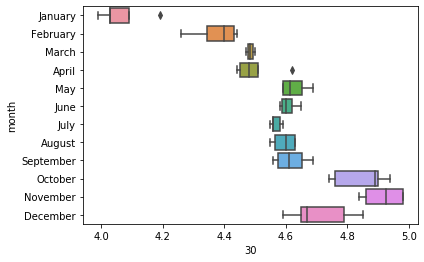

In [22]:
sns.boxplot(x="30",y="month",data=go);

In [22]:
pigo=go.pivot(columns="month", values="30").fillna(-1)
pigo.head()

month,April,August,December,February,January,July,June,March,May,November,October,September
52,-1.0,-1.0,-1.0,-1.0,4.03,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
53,-1.0,-1.0,-1.0,-1.0,3.99,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
54,-1.0,-1.0,-1.0,-1.0,4.03,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
55,-1.0,-1.0,-1.0,-1.0,4.09,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
56,-1.0,-1.0,-1.0,-1.0,4.19,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [71]:
go.dtypes

30       float64
month     object
dtype: object

In [23]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [26]:
truncate(4.87,1)

4.8

In [24]:
go["t"]=[truncate(i,1)for i in go["30"]]

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
round(4.813730094504302,2)

4.81

In [81]:
round(4.813730094504302,1)

4.8

In [37]:
go.where(go["t"]==4.8).dropna()["month"].mode()[0]

'November'

In [28]:
get_date(122)

4.736003408060352


'October'

In [193]:
go= go.to_csv("go.csv")

In [31]:
def get_date(i): 
    l=[one["interest_rate"][i],one["loan_amount"][i],one["property_value"][i],one["cost"][i],one["loan_term"][i]]
    loan=Loan(principal=l[1], interest=float(l[0])/100, term=30)
    mon=float(loan.monthly_payment)
    x=[-l[1]+l[3]]+(np.ones(360)*mon).tolist()
    v=irr.irr_newton(x)*12*100
    #print(v)
    r=v-one["rate_spread"][i]
    r1=round(r,1)
    r2=round(r,2)
    
    m=go.where(go["t"]==r1).dropna()["month"].reset_index()["month"].unique()
    y=[]
    for i in m: 
        x=min(abs(r2-pigo[i]))
        y.append(x)
    return m[y.index(min(y))]

    

In [33]:
len(error)/len(one)

0.0620384047267356

In [32]:
f=[]
error=[]
for i in range(len(one)): 
    try: 
        f.append(get_date(i))
    except: 
        error.append(i)
        print(i)

3
21
34
133
160
163
170
194
219
224
231
236
239
254
285
287
321
339
343
348
352
412
413
421
457
465
500
502
503
508
523
525
526
544
545
550
558
560
593
624
660
664


In [34]:
one=one.drop(error)
one["est_month"]= f

In [35]:
one["est_month"].value_counts()

February     125
January      100
December      72
April         56
March         54
October       48
May           48
June          45
August        38
July          29
November      13
September      7
Name: est_month, dtype: int64

In [31]:
go.groupby("month").mean()["30"].sort_values()

month
January      4.0660
February     4.3750
March        4.4850
April        4.5000
July         4.5680
August       4.5950
June         4.6075
September    4.6175
May          4.6275
December     4.7100
October      4.8460
November     4.9175
Name: 30, dtype: float64

In [32]:
one.shape

(635, 46)

In [32]:
one["interest_rate"]=one["interest_rate"].astype(float)
one["interest_basis_points"]=one["interest_rate"]*100

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


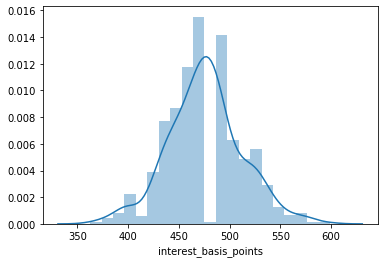

In [34]:
sns.distplot(one["interest_basis_points"])

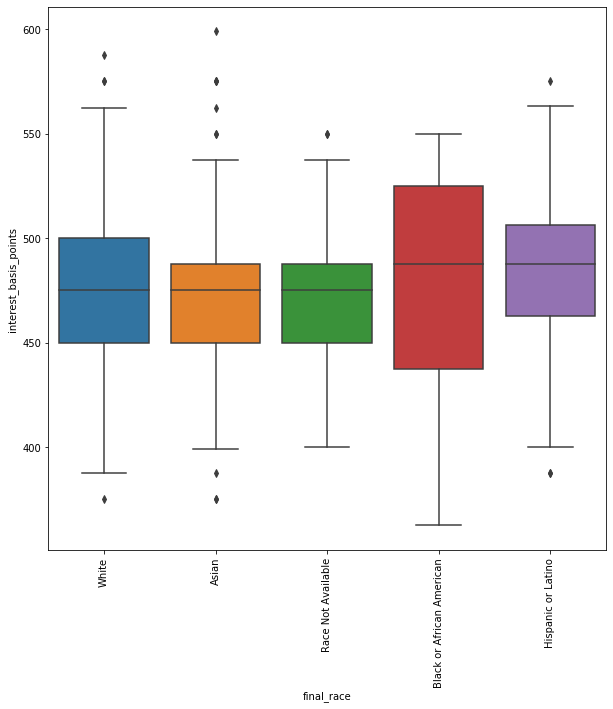

In [35]:
plt.figure(figsize=(10,10))
sns.boxplot(y="interest_basis_points",x="final_race",data=one);
plt.xticks(rotation=90);

In [36]:
one.groupby("final_race").mean()["interest_basis_points"]

final_race
Asian                        471.713990
Black or African American    481.512500
Hispanic or Latino           483.818391
Race Not Available           474.386667
White                        476.202075
Name: interest_basis_points, dtype: float64

In [37]:
one["bin_loan_amount"]=pd.qcut(one["loan_amount"], 4,labels=["below 25th percentile","between 25th percentile and 50th percentile","between 50th percentile and 75th percentile","greater than 75th percentile"])

In [33]:
av=pd.read_csv("avg_credit.csv")
av.head()

,MSA,credit_score
0,10180,746.121925
1,10380,724.777778
2,10420,731.569730
3,10500,762.544974
4,10540,762.322640


In [34]:
av.index= av["MSA"]

In [35]:
def md_MSA(md): 
    if (md==14484) |(md==15764)|(md==37764)|(md==40484):
        return 14460
    elif (md==16974) |(md==23844)|(md==29404): 
        return 16980
    elif (md==19124) |(md==23104): 
        return 19100
    elif (md==19804) |(md==47644):
        return 19820
    elif (md==31084) |(md==42044): 
        return 31100
    elif (md==22744) |(md==33124)|(md==48424):
        return 33100
    elif (md==20764) |(md==35004)|(md==35084)|(md==35644): 
        return 35620
    elif (md==15804) |(md==37964)|(md==48864):
        return 37980
    elif (md==36084) |(md==41884):
        return 41860 
    elif (md==42644) |(md==45104): 
          return 42660 
    elif (md==13644) |(md==47894): 
          return 47900
    
    
        

In [36]:
one["av_credit"]=av["credit_score"][md_MSA(36084)]

In [37]:
av["credit_score"][md_MSA(36084)]

754.9814830989606

In [38]:
cr=one[["bin_lv","total_units","debt_to_income_ratio","av_credit"]]

In [39]:
X=pd.get_dummies(cr[["bin_lv","debt_to_income_ratio","total_units"]])
X["av_credit"]= cr["av_credit"]

In [40]:
import pickle
pkl_filename = "credit_model.pkl"
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [41]:
predict=pickle_model.predict(X)

In [42]:
one["predicted_credit_score"]=predict

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


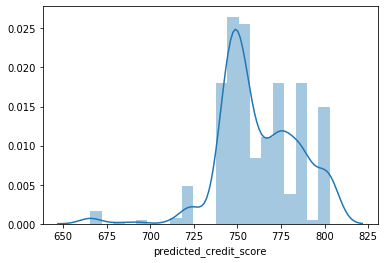

In [43]:
sns.distplot(one["predicted_credit_score"]);

In [44]:
g_fee=pd.read_csv(r"C:\Users\Pavan\OneDrive\Desktop\llp.csv")
g_fee

,credit,< 60.00%,60.01 – 70.00%,70.01 – 75.00%,75.01 – 80.00%,80.01 – 85.00%,85.01 – 90.00%,90.01 – 95.00%,95.01 – 97.00%,>97.00%
0,≥ 740,0.00%,0.25%,0.25%,0.50%,0.25%,0.25%,0.25%,0.75%,0.75%
1,720 – 739,0.00%,0.25%,0.50%,0.75%,0.50%,0.50%,0.50%,1.00%,1.00%
2,700 – 719,0.00%,0.50%,1.00%,1.25%,1.00%,1.00%,1.00%,1.50%,1.50%
3,680 – 699,0.00%,0.50%,1.25%,1.75%,1.50%,1.25%,1.25%,1.50%,1.50%
4,660 – 679,0.00%,1.00%,2.25%,2.75%,2.75%,2.25%,2.25%,2.25%,2.25%
5,640 – 659,0.50%,1.25%,2.75%,3.00%,3.25%,2.75%,2.75%,2.75%,2.75%
6,620 – 639,0.50%,1.50%,3.00%,3.00%,3.25%,3.25%,3.25%,3.50%,3.50%
7,< 620,0.50%,1.50%,3.00%,3.00%,3.25%,3.25%,3.25%,3.75%,3.75%


In [45]:
g_fee=g_fee.replace(to_replace=r'%', value='',regex=True)

In [46]:
g_fee.index=g_fee["credit"]
g_fee=g_fee.drop("credit",axis=1)

In [47]:
g_fee=g_fee.astype(float)

In [196]:
g_fee.to_csv("gfee.csv")

In [48]:
l=[]
for i in one['loan_to_value_ratio']: 
    if i<=60: 
        l.append(g_fee.columns[0])
    if i>= 60.01 and i<=70: 
        l.append(g_fee.columns[1])
    if i>= 70.01 and i<=75: 
        l.append(g_fee.columns[2])
    if i>= 75.01 and i<=80: 
        l.append(g_fee.columns[3])
    if i>= 80.01 and i<=85: 
        l.append(g_fee.columns[4])
    if i>= 85.01 and i<=90: 
        l.append(g_fee.columns[5])
    if i>= 90.01 and i<=95: 
        l.append(g_fee.columns[6])
    if i>= 95.01 and i<=97: 
        l.append(g_fee.columns[7])
    if i>97: 
        l.append(g_fee.columns[8])
one["gltv"]= l

In [76]:
g_fee.index

Index(['≥ 740', '720 – 739', '700 – 719', '680 – 699', '660 – 679',
       '640 – 659', '620 – 639', '< 620 '],
      dtype='object', name='credit')

In [49]:
l=[]
for i in one['predicted_credit_score']: 
    if i<620: 
        l.append(g_fee.index[-1])
    if i>= 620 and i<=639: 
        l.append(g_fee.index[-2])
    if i>= 640 and i<=659: 
        l.append(g_fee.index[-3])
    if i>= 660 and i<=679: 
        l.append(g_fee.index[-4])
    if i>= 680 and i<=699: 
        l.append(g_fee.index[-5])
    if i>= 700 and i<=719: 
        l.append(g_fee.index[-6])
    if i>= 720 and i<=739: 
        l.append(g_fee.index[-7])
    if i>= 740: 
        l.append(g_fee.index[-8])
one["cltv"]= l

In [50]:
one=one.reset_index().drop("index",axis=1)

In [57]:
one["total_units"][0]

'1'

In [51]:
g=[]
for i in range(len(one)): 
    cred=one["cltv"][i]
    ltv=one["gltv"][i]
    t=one["total_units"][i]
    k=g_fee[ltv][cred]
    if t=="1": 
        g.append(k)
    else: 
        g.append(k+1)
one["g_fee"]=g

In [52]:
one["g_basis"]=100*one["g_fee"]

In [53]:
one["g_basis"].value_counts()

25.0     301
50.0     183
0.0      108
75.0      17
100.0      9
150.0      6
125.0      5
225.0      4
275.0      2
Name: g_basis, dtype: int64

In [54]:
one["lender_credits"]=one["lender_credits"].astype(float)

In [55]:
one["discount"]= one["discount_points"]-one["lender_credits"]

In [56]:
one["discount"]=one["discount"]/one["loan_amount"]*1*100

In [57]:
one["discount"]=one["discount_points"]/one["loan_amount"]*1*100

In [91]:
one.columns

Index(['derived_msa-md', 'final_race', 'applicant_age', 'debt_to_income_ratio',
       'Cost_of_Loan', 'derived_sex', 'loan_to_value_ratio', 'rate_spread',
       'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'lei', 'state_code', 'county_code',
       'census_tract', 'loan_amount', 'hoepa_status', 'property_value',
       'total_units', 'aus', 'tract_to_msa_income_percentage',
       'open-end_line_of_credit', 'tract_owner_occupied_units',
       'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units',
       'income', 'Asian%_tract', 'Black or African American%_tract',
       'Hispanic or Latino (of any race)%_tract', 'White%_tract',
       'interest_rate', 'loan_term', 'intro_rate_period',
       'interest_only_payment', 'balloon_payment', 'negative_amortization',
       'other_nonamortizing_features', 'purchaser_type',
       'prepayment_penalty_term', 'discount_points', 'lender_credits',
       'origination_charges', 'cost', 'bin_inc

In [58]:
one["origination_charges"]= one["origination_charges"]/one["loan_amount"]*1*100

In [85]:
two=one.copy()

In [86]:
regression=["final_race","derived_sex",'applicant_age',"lei","est_month",'g_basis',"county_code","discount",'interest_basis_points',"origination_charges"]
cat=["final_race","derived_sex",'applicant_age',"lei","est_month",'g_basis',"county_code"]


In [87]:
two=two[regression]


In [88]:
two["g_basis"]=two["g_basis"].astype(str)

In [89]:
cont=two["county_code"].value_counts().index

In [90]:
c=cont[0]

In [65]:
one["bin_income"].value_counts()

below 25th percentile                          162
greater than 75th percentile                   161
between 25th percentile and 50th percentile    158
between 50th percentile and 75th percentile    154
Name: bin_income, dtype: int64

In [91]:
big=v["lei"][0]

In [93]:
cate=pd.get_dummies(two[cat]).drop(["final_race_White","lei_"+big,"derived_sex_Male",'applicant_age_45-54','est_month_January',"g_basis_0.0",'county_code_'+c],axis=1)
cate.head()

,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,final_race_Race Not Available,derived_sex_Female,derived_sex_Joint,derived_sex_Sex Not Available,applicant_age_25-34,applicant_age_35-44,applicant_age_55-64,...,est_month_September,g_basis_100.0,g_basis_125.0,g_basis_150.0,g_basis_225.0,g_basis_25.0,g_basis_275.0,g_basis_50.0,g_basis_75.0,county_code_06001
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [94]:
cate=cate.apply(lambda x: x-x.mean())

In [95]:
co=["lei_"+i for i in v["lei"]]
co=co[1:]

In [96]:
for i in co: 
    cate[i+"discount"]=cate[i]*two["discount"]

In [97]:
for i in co: 
    cate[i+"origination_charges"]=cate[i]*two["origination_charges"]

In [98]:
cate.head()

,final_race_Asian,final_race_Black or African American,final_race_Hispanic or Latino,final_race_Race Not Available,derived_sex_Female,derived_sex_Joint,derived_sex_Sex Not Available,applicant_age_25-34,applicant_age_35-44,applicant_age_55-64,...,lei_C5654JQHZUHN0772B561origination_charges,lei_549300EM6UG8HE3P8U74origination_charges,lei_549300QU7HWSPH011Y56origination_charges,lei_254900R9A6TW85BTVS20origination_charges,lei_OX3PU53ZLPQKJ4700D47origination_charges,lei_AD6GFRVSDT01YPT1CS68origination_charges,lei_549300SSW7BYB4WN4238origination_charges,lei_549300JOT0D4J0SZIK67origination_charges,lei_549300VRYDYOPWK5MO08origination_charges,lei_549300DCGBXW5FJMV921origination_charges
0,-0.303937,-0.037795,-0.137008,-0.141732,-0.264567,0.645669,-0.050394,-0.338583,-0.286614,-0.111811,...,-0.003946,-0.003482,-0.002786,-0.003250,-0.003250,-0.002786,-0.002554,-0.002321,-0.002786,-0.002786
1,0.696063,-0.037795,-0.137008,-0.141732,-0.264567,-0.354331,-0.050394,-0.338583,0.713386,-0.111811,...,-0.008063,-0.007114,-0.005691,-0.006640,-0.006640,-0.005691,-0.005217,-0.004743,-0.005691,-0.005691
2,0.696063,-0.037795,-0.137008,-0.141732,-0.264567,0.645669,-0.050394,-0.338583,0.713386,-0.111811,...,-0.005275,-0.004654,-0.003723,-0.004344,-0.004344,-0.003723,-0.003413,-0.003103,-0.003723,-0.003723
3,-0.303937,-0.037795,-0.137008,-0.141732,-0.264567,0.645669,-0.050394,-0.338583,0.713386,-0.111811,...,-0.010850,-0.009574,-0.007659,-0.008935,-0.008935,-0.007659,-0.007021,-0.006382,-0.007659,-0.007659
4,-0.303937,-0.037795,-0.137008,-0.141732,0.735433,-0.354331,-0.050394,-0.338583,-0.286614,-0.111811,...,-0.033978,-0.029981,-0.023984,-0.027982,-0.027982,-0.023984,-0.021986,-0.019987,-0.023984,-0.023984


In [99]:
cate["discount"]=two["discount"]
#cate["lender_credits"]=two["lender_credits"]
cate["origination_charges"]= two["origination_charges"]
f=list(cate.columns)+["intercept"]

In [107]:
one["discount"].skew()

-0.5512548789260583

In [100]:
cate.columns

Index(['final_race_Asian', 'final_race_Black or African American',
       'final_race_Hispanic or Latino', 'final_race_Race Not Available',
       'derived_sex_Female', 'derived_sex_Joint',
       'derived_sex_Sex Not Available', 'applicant_age_25-34',
       'applicant_age_35-44', 'applicant_age_55-64',
       ...
       'lei_549300QU7HWSPH011Y56origination_charges',
       'lei_254900R9A6TW85BTVS20origination_charges',
       'lei_OX3PU53ZLPQKJ4700D47origination_charges',
       'lei_AD6GFRVSDT01YPT1CS68origination_charges',
       'lei_549300SSW7BYB4WN4238origination_charges',
       'lei_549300JOT0D4J0SZIK67origination_charges',
       'lei_549300VRYDYOPWK5MO08origination_charges',
       'lei_549300DCGBXW5FJMV921origination_charges', 'discount',
       'origination_charges'],
      dtype='object', length=119)

In [101]:
cate["intercept"]=1

In [102]:
Y= two[['interest_basis_points']]

In [103]:
model = sm.OLS(Y,cate).fit(method='pinv')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     interest_basis_points   R-squared:                       0.533
Model:                               OLS   Adj. R-squared:                  0.425
Method:                    Least Squares   F-statistic:                     4.938
Date:                   Wed, 25 Nov 2020   Prob (F-statistic):           3.01e-37
Time:                           12:34:45   Log-Likelihood:                -2943.9
No. Observations:                    635   AIC:                             6128.
Df Residuals:                        515   BIC:                             6662.
Df Model:                            119                                         
Covariance Type:               nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
final_race_Asian                                0.0672      3.228      0.021      0.983      -6.274       6.409
final_race_Black or African American           13.3267      6.597      2.020      0.044       0.366      26.287
final_race_Hispanic or Latino                   6.3417      4.011      1.581      0.114      -1.538      14.222
final_race_Race Not Available                   6.8809      4.490      1.532      0.126      -1.941      15.703
derived_sex_Female                             -0.0966      3.186     -0.030      0.976      -6.355       6.162
derived_sex_Joint                              -1.2224      2.979     -0.410      0.682      -7.075       4.630
derived_sex_Sex Not Available                  -1.8384      6.970     -0.264      0.792     -15.532      11.855
applicant_age_25-34                             0.3449      3.779      0.091      0.927      -7.080       7.770
applicant_age_35-44                             2.7493      3.788      0.726      0.468      -4.693      10.192
applicant_age_55-64                             6.7921      4.884      1.391      0.165      -2.803      16.387
applicant_age_65-74                            -4.6230      6.959     -0.664      0.507     -18.294       9.048
applicant_age_<25                               3.4769      7.355      0.473      0.637     -10.973      17.927
applicant_age_>74                              -0.4891     10.361     -0.047      0.962     -20.845      19.867
lei_254900R9A6TW85BTVS20                       11.3020     16.160      0.699      0.485     -20.446      43.050
lei_254900TTZ395IC926125                       -2.9254     16.488     -0.177      0.859     -35.318      29.467
lei_54930001NSTOD85LT125                       -7.1832     23.214     -0.309      0.757     -52.788      38.422
lei_549300121SF0K2LN2804                       22.8843     16.908      1.353      0.176     -10.332      56.101
lei_5493001SDQVS1NWYH012                       39.8793     23.701      1.683      0.093      -6.683      86.441
lei_54930043BMDE130FJ617                      -34.7176     21.500     -1.615      0.107     -76.957       7.521
lei_5493004AS1SPBQOFDR49                       21.4441     19.792      1.083      0.279     -17.438      60.326
lei_5493008VVXQIDO1EZ460                       51.8975     33.439      1.552      0.121     -13.797     117.592
lei_5493009DTDMV4MI5MT96                      -20.9541     14.584     -1.437      0.151     -49.605       7.697
lei_549300BRJZYHYKT4BJ84                       -4.8507     14.905     -0.325      0.745     -34.132      24.431
lei_549300DCGBXW5FJMV921                        0.9804     28.142      0.035      0.972     -54.306      56.267
lei_549300E2UX99HKDBR481  

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


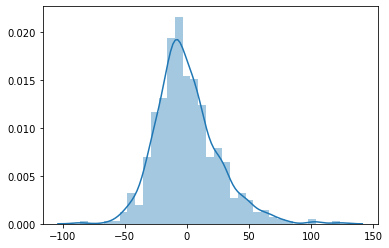

In [104]:
sns.distplot(model.resid)

In [105]:
model.resid.skew()

0.7982333139244155

In [119]:
         
        
def multicollinearity_assumption():

        from statsmodels.stats.outliers_influence import variance_inflation_factor
      
        features=cate.values
        
        VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
        race=["final_race_Asian","final_race_Black or African American","final_race_Hispanic or Latino"]
        VIF=VIF[:3]
        for vif in VIF:
            assert vif<2.5
        
def normal_resid(): 
    assert model.resid.skew()<1.2 and model.resid.skew()>-1.2
        
        
            
def homoscedasticity_assumption():
       assert np.isclose(np.corrcoef(model.predict(cate),model.resid)[0][1],0)
def autocorrelation_assumption(): 
    from statsmodels.stats.stattools import durbin_watson
    durbinWatson = durbin_watson(model.resid)
    assert durbinWatson>1.5 and durbinWatson<2.5

In [189]:
values=pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
values["r^2"]=model.rsquared_adj

In [120]:
normal_resid()

In [113]:
multicollinearity_assumption()

In [118]:
autocorrelation_assumption()

In [285]:
feat.shape[1]

46

In [116]:
homoscedasticity_assumption()

In [121]:
deep=pd.read_csv(r"C:\Users\Pavan\OneDrive\Desktop\deepsolar.csv",encoding='latin-1')
deep.head()

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,...,39,11,13,34,0,0,25,12,0,9.46


In [122]:
deep["county"]=deep["county"].replace(r" County","",regex=True)

In [124]:
names=pd.read_csv(r"C:\Users\Pavan\OneDrive\Desktop\FipsCountyCodes.csv")
names.head()

,FIPS,Name
0,2000,AK
1,2013,"AK, Aleutians East"
2,2016,"AK, Aleutians West"
3,2020,"AK, Anchorage"
4,2050,"AK, Bethel"


In [125]:
names["county"]=names["Name"].str.split(",",expand=True)[1]

In [126]:
names.head()

,FIPS,Name,county
0,2000,AK,None
1,2013,"AK, Aleutians East",Aleutians East
2,2016,"AK, Aleutians West",Aleutians West
3,2020,"AK, Anchorage",Anchorage
4,2050,"AK, Bethel",Bethel


In [127]:
names["FIPS"]=names["FIPS"].astype(str)

In [128]:
names["FIPS"]=["0"+i for i in names["FIPS"]]

In [129]:
names.to_csv("names.csv")

In [130]:
nc=[names[names["FIPS"]==i]["county"].reset_index()["county"][0] for i in cont]

In [131]:
nc

[' Contra Costa', ' Alameda']

In [132]:
nc=pd.Series(nc).str.replace(' ', '')

In [133]:
deep.head()

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns,569,1690,13,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns,674,1434,108,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns,854,1459,31,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns,640,1116,68,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns,654,1314,15,...,39,11,13,34,0,0,25,12,0,9.46


In [134]:
deep["county"]=deep["county"].str.replace(' ', '')

In [135]:
deep.to_csv("deep.csv")

In [136]:
deep[deep["county"]==nc[0]].head()

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
17961,17961,504.0,313.0,26673.437574,6013322000,118323.924407,ContraCosta,1657,1333,58,...,85,15,16,21,9,0,38,0,10,14.72
17962,17962,203.0,159.0,4603.864638,6013323000,105614.709302,ContraCosta,1039,1012,56,...,85,15,16,21,9,0,38,0,10,14.72
17963,17963,63.0,47.0,2917.168901,6013324001,81267.077230,ContraCosta,1626,788,43,...,85,15,16,21,9,0,38,0,10,14.72
17964,17964,104.0,79.0,3524.265804,6013324002,95847.801069,ContraCosta,1299,1505,41,...,85,15,16,21,9,0,38,0,10,14.72
17965,17965,337.0,250.0,13353.400067,6013325000,108472.342384,ContraCosta,1520,1441,8,...,85,15,16,21,9,0,38,0,10,14.72


In [221]:
sum(deep["county"]=="Alameda")

361

In [137]:
filtered=pd.DataFrame()
for i in nc: 
    filtered=pd.concat([deep[deep["county"]==i],filtered])

In [138]:
filtered.shape

(569, 169)

In [139]:
filtered=filtered.reset_index().drop(["index","Unnamed: 0"],axis=1)
filtered.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,108.0,89.0,2035.838260,6001442400,119109.409969,Alameda,873,1333,75,1442,...,85,15,16,21,9,0,38,0,10,14.72
1,32.0,26.0,605.412743,6001437600,70079.035874,Alameda,256,686,11,652,...,85,15,16,21,9,0,38,0,10,14.72
2,85.0,67.0,2442.808845,6001438000,88930.291628,Alameda,664,703,58,543,...,85,15,16,21,9,0,38,0,10,14.72
3,175.0,137.0,4648.216168,6001438100,96955.167464,Alameda,767,1405,24,1695,...,85,15,16,21,9,0,38,0,10,14.72
4,177.0,150.0,4642.632173,6001400100,238370.839813,Alameda,756,368,214,83,...,85,15,16,21,9,0,38,0,10,14.72


In [140]:
query='''SELECT "id","Asian%_tract","Black or African American%_tract","Hispanic or Latino (of any race)%_tract","White%_tract"
From Census_Tract'''
census=pd.read_sql_query(query, con)
census.head()

,id,Asian%_tract,Black or African American%_tract,Hispanic or Latino (of any race)%_tract,White%_tract
0,01001020100,0.9,8.4,3.5,83.7
1,01001020200,0.9,55.7,1.8,40.4
2,01001020300,0.9,21.0,8.6,66.3
3,01001020400,0.2,7.7,2.3,88.3
4,01001020500,3.5,16.9,1.2,77.4


In [246]:
census[]

id                                         object
Asian%_tract                               object
Black or African American%_tract           object
Hispanic or Latino (of any race)%_tract    object
White%_tract                               object
dtype: object

In [141]:
census["id"]=census["id"].astype(str)

In [142]:
filtered["fips"]=filtered["fips"].astype(str)
filtered["fips"]=["0"+i for i in filtered["fips"]]

In [192]:
census.to_csv("census")

In [143]:
filtered=filtered.merge(census, left_on="fips",right_on="id")

In [335]:
filtered.shape

(567, 173)

In [144]:
filtered["Asian%_tract"]=filtered["Asian%_tract"].astype(float)
filtered["Black or African American%_tract"]=filtered["Black or African American%_tract"].astype(float)
filtered["Hispanic or Latino (of any race)%_tract"]=filtered["Hispanic or Latino (of any race)%_tract"].astype(float)
filtered["White%_tract"]=filtered["White%_tract"].astype(float)

In [145]:
l=[]
for i in range(len(filtered)):
    asian= filtered["Asian%_tract"][i]
    black= filtered["Black or African American%_tract"][i]
    hispanic= filtered["Hispanic or Latino (of any race)%_tract"][i]
    white= filtered["White%_tract"][i]
    x=np.array([asian,black,white,hispanic])
    sor=np.argsort(x)
    first=sor[-1]
    second= sor[-2]
    y=["asian","black","white","hispanic"]
    
    if asian>=50: 
        l.append("Majority Asian")
    elif black>=50: 
            l.append("Majority Black")
    elif hispanic>=50: 
        l.append("Majority Hispanic")
    elif white>50: 
        l.append("Majority White")
    else: 
        if x[first]-x[second]<10:
            l.append(y[first]+y[second])
        else: 
            l.append("No Majority")
filtered["Majority"]=l

In [146]:
filtered["Majority"].value_counts()

Majority White       256
No Majority           97
Majority Hispanic     57
Majority Asian        54
whiteasian            19
asianwhite            19
hispanicwhite         18
whitehispanic         13
whiteblack             7
blackwhite             7
Majority Black         6
hispanicasian          5
hispanicblack          4
asianhispanic          4
blackasian             1
Name: Majority, dtype: int64

In [147]:
filtered[(filtered["Majority"]=="whiteasian")|(filtered["Majority"]=="asianwhite")].head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,property_tax,sales_tax,rebate,avg_electricity_retail_rate,id,Asian%_tract,Black or African American%_tract,Hispanic or Latino (of any race)%_tract,White%_tract,Majority
87,30.0,27.0,658.323631,06001440100,78144.411178,Alameda,390,499,13,602,...,38,0,10,14.72,06001440100,36.8,2.0,19.1,43.2,whiteasian
103,119.0,98.0,2279.748738,06001441800,116898.401728,Alameda,1177,1177,329,1043,...,38,0,10,14.72,06001441800,46.8,1.6,14.7,37.9,asianwhite
116,37.0,32.0,790.399176,06001420300,124659.862869,Alameda,1145,580,283,191,...,38,0,10,14.72,06001420300,41.6,1.9,14.8,33.9,asianwhite
118,31.0,14.0,2694.626752,06001422600,397940.000000,Alameda,123,13,10,0,...,38,0,10,14.72,06001422600,40.3,4.0,13.3,47.2,whiteasian
121,29.0,26.0,815.608696,06001422800,35190.420900,Alameda,447,445,34,116,...,38,0,10,14.72,06001422800,43.4,4.0,17.0,37.7,asianwhite


In [148]:
hr=pd.read_csv(r"C:\Users\Pavan\OneDrive\Desktop\hr\homerent.csv")
hr.head()

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GEO_ID,NAME,B25008_001E,B25008_001M,B25008_002E,B25008_002M,B25008_003E,B25008_003M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Owner occupied,Margin of Error!!Total!!Owner occupied,Estimate!!Total!!Renter occupied,Margin of Error!!Total!!Renter occupied
1,1400000US01073005701,"Census Tract 57.01, Jefferson County, Alabama",2462,317,1256,257,1206,411
2,1400000US01073010704,"Census Tract 107.04, Jefferson County, Alabama",3024,312,1619,259,1405,292
3,1400000US01073012908,"Census Tract 129.08, Jefferson County, Alabama",6043,836,1927,388,4116,919
4,1400000US01073005302,"Census Tract 53.02, Jefferson County, Alabama",3628,469,2632,416,996,545


In [149]:
mo=pd.read_csv(r"C:\Users\Pavan\OneDrive\Desktop\mo\mo.csv")
mo.head()

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GEO_ID,NAME,B25027_001E,B25027_001M,B25027_002E,B25027_002M,B25027_003E,B25027_003M,B25027_004E,B25027_004M,...,B25027_013E,B25027_013M,B25027_014E,B25027_014M,B25027_015E,B25027_015M,B25027_016E,B25027_016M,B25027_017E,B25027_017M
0,id,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,Estimate!!Total!!Housing units with a mortgage,Margin of Error!!Total!!Housing units with a m...,Estimate!!Total!!Housing units with a mortgage...,Margin of Error!!Total!!Housing units with a m...,Estimate!!Total!!Housing units with a mortgage...,Margin of Error!!Total!!Housing units with a m...,...,Estimate!!Total!!Housing units without a mortg...,Margin of Error!!Total!!Housing units without ...,Estimate!!Total!!Housing units without a mortg...,Margin of Error!!Total!!Housing units without ...,Estimate!!Total!!Housing units without a mortg...,Margin of Error!!Total!!Housing units without ...,Estimate!!Total!!Housing units without a mortg...,Margin of Error!!Total!!Housing units without ...,Estimate!!Total!!Housing units without a mortg...,Margin of Error!!Total!!Housing units without ...
1,1400000US01073005701,"Census Tract 57.01, Jefferson County, Alabama",590,111,226,102,22,35,17,25,...,13,23,28,32,137,90,67,44,74,53
2,1400000US01073010704,"Census Tract 107.04, Jefferson County, Alabama",593,82,444,72,80,45,62,41,...,23,27,18,23,20,22,20,20,39,31
3,1400000US01073012908,"Census Tract 129.08, Jefferson County, Alabama",833,144,562,132,212,114,140,83,...,27,32,45,46,32,39,19,30,127,65
4,1400000US01073005302,"Census Tract 53.02, Jefferson County, Alabama",1175,126,721,132,55,46,135,54,...,84,66,35,31,74,47,98,53,146,74


In [150]:
hr=hr[["GEO_ID","B25008_002E","B25008_003E","NAME"]]
hr.head()

,GEO_ID,B25008_002E,B25008_003E,NAME
0,id,Estimate!!Total!!Owner occupied,Estimate!!Total!!Renter occupied,Geographic Area Name
1,1400000US01073005701,1256,1206,"Census Tract 57.01, Jefferson County, Alabama"
2,1400000US01073010704,1619,1405,"Census Tract 107.04, Jefferson County, Alabama"
3,1400000US01073012908,1927,4116,"Census Tract 129.08, Jefferson County, Alabama"
4,1400000US01073005302,2632,996,"Census Tract 53.02, Jefferson County, Alabama"


In [151]:
hr["GEO_ID"]=hr["GEO_ID"].str.replace("1400000US","")
hr.columns= hr.iloc[0]
hr=hr.drop(0)
hr.head()

,id,Estimate!!Total!!Owner occupied,Estimate!!Total!!Renter occupied,Geographic Area Name
1,01073005701,1256,1206,"Census Tract 57.01, Jefferson County, Alabama"
2,01073010704,1619,1405,"Census Tract 107.04, Jefferson County, Alabama"
3,01073012908,1927,4116,"Census Tract 129.08, Jefferson County, Alabama"
4,01073005302,2632,996,"Census Tract 53.02, Jefferson County, Alabama"
5,01073011107,10654,786,"Census Tract 111.07, Jefferson County, Alabama"


In [152]:
hr["ratio"]=hr["Estimate!!Total!!Owner occupied"].astype(float)/hr["Estimate!!Total!!Renter occupied"].astype(float)

In [154]:
hr.to_csv("hr.csv")

In [155]:
filtered=filtered.merge(hr[["id","ratio"]], left_on="fips",right_on="id")
filtered.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,rebate,avg_electricity_retail_rate,id_x,Asian%_tract,Black or African American%_tract,Hispanic or Latino (of any race)%_tract,White%_tract,Majority,id_y,ratio
0,108.0,89.0,2035.838260,06001442400,119109.409969,Alameda,873,1333,75,1442,...,10,14.72,06001442400,48.8,3.4,23.9,29.1,No Majority,06001442400,1.768878
1,32.0,26.0,605.412743,06001437600,70079.035874,Alameda,256,686,11,652,...,10,14.72,06001437600,28.5,8.8,44.0,34.4,hispanicwhite,06001437600,1.619645
2,85.0,67.0,2442.808845,06001438000,88930.291628,Alameda,664,703,58,543,...,10,14.72,06001438000,27.5,4.2,36.9,49.1,No Majority,06001438000,1.407429
3,175.0,137.0,4648.216168,06001438100,96955.167464,Alameda,767,1405,24,1695,...,10,14.72,06001438100,29.7,7.4,38.2,32.6,hispanicwhite,06001438100,1.980676
4,177.0,150.0,4642.632173,06001400100,238370.839813,Alameda,756,368,214,83,...,10,14.72,06001400100,19.2,4.1,3.3,68.1,Majority White,06001400100,8.215976


In [156]:
mo=mo[["GEO_ID","B25027_001E","B25027_002E","NAME"]]
mo["GEO_ID"]=mo["GEO_ID"].str.replace("1400000US","")
mo.columns= mo.iloc[0]
mo=mo.drop(0)
mo.head()

,id,Estimate!!Total,Estimate!!Total!!Housing units with a mortgage,Geographic Area Name
1,01073005701,590,226,"Census Tract 57.01, Jefferson County, Alabama"
2,01073010704,593,444,"Census Tract 107.04, Jefferson County, Alabama"
3,01073012908,833,562,"Census Tract 129.08, Jefferson County, Alabama"
4,01073005302,1175,721,"Census Tract 53.02, Jefferson County, Alabama"
5,01073011107,3708,2869,"Census Tract 111.07, Jefferson County, Alabama"


In [157]:
mo["mratio"]=mo["Estimate!!Total!!Housing units with a mortgage"].astype(float)/mo["Estimate!!Total"].astype(float)

In [159]:
mo.to_csv("mo.csv")

In [160]:
house=pd.read_csv(r"C:\Users\Pavan\OneDrive\Desktop\h\home.csv")
house.head()

C:\Users\Pavan\anaconda3\envs\myenv_conda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,22,23,24,25,26,27,28,29,42,43,44,45,46,47,48,49,82,83,84,85,86,87,88,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GEO_ID,NAME,S1101_C01_001E,S1101_C01_001M,S1101_C02_001E,S1101_C02_001M,S1101_C03_001E,S1101_C03_001M,S1101_C04_001E,S1101_C04_001M,...,S1101_C01_020E,S1101_C01_020M,S1101_C02_020E,S1101_C02_020M,S1101_C03_020E,S1101_C03_020M,S1101_C04_020E,S1101_C04_020M,S1101_C05_020E,S1101_C05_020M
0,id,Geographic Area Name,Estimate!!Total!!HOUSEHOLDS!!Total households,Margin of Error!!Total MOE!!HOUSEHOLDS!!Total ...,Estimate!!Married-couple family household!!HOU...,Margin of Error!!Married-couple family househo...,"Estimate!!Male householder, no wife present, f...","Margin of Error!!Male householder, no wife pre...","Estimate!!Female householder, no husband prese...","Margin of Error!!Female householder, no husban...",...,Estimate!!Total!!Total households!!HOUSING TEN...,Margin of Error!!Total MOE!!Total households!!...,Estimate!!Married-couple family household!!Tot...,Margin of Error!!Married-couple family househo...,"Estimate!!Male householder, no wife present, f...","Margin of Error!!Male householder, no wife pre...","Estimate!!Female householder, no husband prese...","Margin of Error!!Female householder, no husban...",Estimate!!Nonfamily household!!Total household...,Margin of Error!!Nonfamily household MOE!!Tota...
1,1400000US10001040100,"Census Tract 401, Kent County, Delaware",2582,142,1238,197,171,87,478,159,...,15.0,5.8,6.7,7.5,0.0,16.0,39.5,19.5,16.5,12.6
2,1400000US10001040201,"Census Tract 402.01, Kent County, Delaware",1870,155,810,126,137,64,411,99,...,36.5,7.1,21.4,8.4,29.9,19.8,49.9,15.0,51.4,12.7
3,1400000US10001040202,"Census Tract 402.02, Kent County, Delaware",5550,416,3370,459,155,89,771,308,...,15.9,3.7,12.2,5.1,0.0,17.5,33.9,17.5,16.7,8.9
4,1400000US10001040203,"Census Tract 402.03, Kent County, Delaware",2058,182,1073,165,0,16,426,161,...,28.9,6.9,13.9,8.4,-,**,52.8,19.9,39.4,16.3


In [161]:
house=house[["GEO_ID","S1101_C01_001E","NAME"]]
house["GEO_ID"]=house["GEO_ID"].str.replace("1400000US","")
house.columns= house.iloc[0]
house=house.drop(0)

In [162]:
house.columns

Index(['id', 'Estimate!!Total!!HOUSEHOLDS!!Total households',
       'Geographic Area Name'],
      dtype='object', name=0)

In [163]:
house.to_csv("house.csv")

In [164]:
filtered=filtered.merge(mo[["id","mratio"]], left_on="fips",right_on="id")
filtered.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,id_x,Asian%_tract,Black or African American%_tract,Hispanic or Latino (of any race)%_tract,White%_tract,Majority,id_y,ratio,id,mratio
0,108.0,89.0,2035.838260,06001442400,119109.409969,Alameda,873,1333,75,1442,...,06001442400,48.8,3.4,23.9,29.1,No Majority,06001442400,1.768878,06001442400,0.686377
1,32.0,26.0,605.412743,06001437600,70079.035874,Alameda,256,686,11,652,...,06001437600,28.5,8.8,44.0,34.4,hispanicwhite,06001437600,1.619645,06001437600,0.704415
2,85.0,67.0,2442.808845,06001438000,88930.291628,Alameda,664,703,58,543,...,06001438000,27.5,4.2,36.9,49.1,No Majority,06001438000,1.407429,06001438000,0.833803
3,175.0,137.0,4648.216168,06001438100,96955.167464,Alameda,767,1405,24,1695,...,06001438100,29.7,7.4,38.2,32.6,hispanicwhite,06001438100,1.980676,06001438100,0.773448
4,177.0,150.0,4642.632173,06001400100,238370.839813,Alameda,756,368,214,83,...,06001400100,19.2,4.1,3.3,68.1,Majority White,06001400100,8.215976,06001400100,0.615717


In [165]:
filtered=filtered.merge(house[['id','Estimate!!Total!!HOUSEHOLDS!!Total households']], left_on="fips",right_on="id")

In [166]:
filtered["bin_ratio"]=pd.qcut(filtered['ratio'], 2,labels=["below 50thth percentile","greater than 50th percentile"])
filtered["bin_mratio"]=pd.qcut(filtered['mratio'], 2,labels=["below 50th percentile","greater than 50th percentile"])

In [167]:
filtered=filtered[(filtered["bin_ratio"]=="greater than 50th percentile") &(filtered["bin_mratio"]=="greater than 50th percentile")]
filtered["Majority"].value_counts()

Majority White       92
Majority Asian       22
No Majority          18
asianwhite            6
whitehispanic         5
whiteasian            4
hispanicwhite         4
blackwhite            3
Majority Black        1
Majority Hispanic     1
asianhispanic         1
Name: Majority, dtype: int64

In [168]:
filtered["number_of_households_solar"]= filtered["solar_system_count_residential"]/filtered["number_of_solar_system_per_household"]

In [169]:
black=filtered[(filtered["Majority"]=="Majority Black")|(filtered["Majority"]=="blackwhite")|(filtered["Majority"]=="whiteblack")|(filtered["Majority"]=="asianblack")|(filtered["Majority"]=="blackasian")|(filtered["Majority"]=="hispanicblack")|(filtered["Majority"]=="blackhispanic")]

In [170]:
black["number_of_households_solar"]

77     1705.0
86      980.0
338    1203.0
442    3643.0
Name: number_of_households_solar, dtype: float64

In [171]:
black_combined_solar=black["number_of_households_solar"].sum()/black["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
black_combined_solar

0.9679948586103025

In [172]:
white=filtered[(filtered["Majority"]=="Majority White")]
white_solar=white["number_of_households_solar"].sum()/white["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
white_solar

0.9688577716929891

In [173]:
asian=filtered[(filtered["Majority"]=="Majority Asian")|(filtered["Majority"]=="blackasian")|(filtered["Majority"]=="asianblack")|(filtered["Majority"]=="asianwhite")|(filtered["Majority"]=="whiteasian")|(filtered["Majority"]=="hispanicasian")|(filtered["Majority"]=="asianhispanic")]
asian_combinedsolar=asian["number_of_households_solar"].sum()/asian["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
asian_combinedsolar

0.9479259569356304

In [174]:
hispanic=filtered[(filtered["Majority"]=="Majority Hispanic")|(filtered["Majority"]=="blackhispanic")|(filtered["Majority"]=="hispanicblack")|(filtered["Majority"]=="asianhispanic")|(filtered["Majority"]=="hispanicasian")|(filtered["Majority"]=="hispanicwhite")|(filtered["Majority"]=="whitehispanic")]
hispanic_combinedsolar=hispanic["number_of_households_solar"].sum()/hispanic["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
hispanic_combinedsolar

0.9825887601460559

In [175]:
black=filtered[(filtered["Majority"]=="Majority Black")]
black_maj=black["number_of_households_solar"].sum()/black["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
black_maj

0.9306742640076782

In [176]:
asian=filtered[(filtered["Majority"]=="Majority Asian")]
asian_maj=asian["number_of_households_solar"].sum()/asian["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
asian_maj

0.946319955377388

In [177]:
hispanic=filtered[(filtered["Majority"]=="Majority Hispanic")]
hispanic_maj=hispanic["number_of_households_solar"].sum()/hispanic["Estimate!!Total!!HOUSEHOLDS!!Total households"].sum()
hispanic_maj

0.957177322073759

In [178]:
rblack_combined_solar=black_combined_solar-white_solar
rasian_combinedsolar=asian_combinedsolar-white_solar
rhispanic_combinedsolar=hispanic_combinedsolar-white_solar
rblack_maj=black_maj-white_solar
rasian_maj=asian_maj-white_solar
rhispanic_maj=hispanic_maj-white_solar

In [179]:
rblack_combined_solar,rasian_combinedsolar,rhispanic_combinedsolar,rblack_maj,rasian_maj,rhispanic_maj

(-0.0008629130826866005,
 -0.020931814757358724,
 0.01373098845306675,
 -0.03818350768531098,
 -0.022537816315601145,
 -0.011680449619230093)